In [1]:
from pathlib import Path
import sqlite3
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from tabulate import tabulate
import seaborn as sns
from scipy.stats import gaussian_kde

/home/mafalda/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# path to arrayrgbase
print("We will use the Database 1, named HumanA_Control.") 
db_path = Path('/home/mafalda/Desktop/DataBases/HumanA_Control.db')

# connect to arrayrgbase
connection = sqlite3.connect(db_path)
cr = connection.cursor()

We will use the Database 1, named HumanA_Control.


In [3]:
# get the node number and coordinates of a specific trial
def get_nodes_and_coordinates_trial(n, b):
    sql_instruction = """
        SELECT dp.node, gc.nodeCentroid_x, gc.nodeCentroid_z
        FROM trials t
        JOIN graph_coordinates gc ON dp.node = gc.nodeNr
        JOIN dataPoints_reduced dp on dp.TrialId = t.Id
        WHERE t.participantId = """ + str(n) + """ AND dp.validDatapoint = 'VALID' AND dp.AdditionalInfo = 'FirstDPofNode' AND sessionNr = """ + str(b) + """
        ORDER BY dp.timeStampDataPointStart ASC
        """
    cr.execute(sql_instruction)
    nodes_and_coordinates = cr.fetchall()
    
    # remove consecutive duplicates from list 
    nodes_coor = [nodes_and_coordinates[0]]
    for i in range(1, len(nodes_and_coordinates)):
        if nodes_and_coordinates[i] != nodes_and_coordinates[i - 1]:
            nodes_coor.append(nodes_and_coordinates[i])
    
    # sperate the values of nodes, X and Y coordinates
    nodes = []
    coor_x = []
    coor_y = []
    for node, x, z in nodes_coor:
        nodes.append(node)
        coor_x.append(x)
        coor_y.append(z)
    
    return nodes, coor_x, coor_y

In [4]:
#  number of total trials in the database
def get_num_trials():
    sql_instruction = """SELECT distinct t.participantId
        FROM trials t
        WHERE t.validParticipant = 'VALID'
        ORDER BY participantId asc
        """
    cr.execute(sql_instruction)
    num = cr.fetchall()
    # get only the number 
    num1 = [tup[0] for tup in num]
    return num1

num_trials = get_num_trials()
print(num_trials)

for i in num_trials:
    for b in range(1,6):
        # get the nodes, X and Y coordinates of the trial
        nodes, coor_x, coor_y = get_nodes_and_coordinates_trial(i, b)
        print(nodes)
        print(i)  # Print just to indicate progress

[1005, 1008, 1010, 1011, 1013, 1017, 1018, 1019, 1021, 1022, 1023, 1054, 1055, 1056, 1057, 1058, 1068, 1069, 1072, 1073, 1074, 1075, 1077, 1079, 1080]
[76, 90, 103, 105, 101, 96, 86, 80, 81, 79, 72, 64, 72, 79, 81, 92, 96, 101, 105, 128, 126, 118, 112, 118, 126, 137, 150, 149, 146, 149, 156, 157, 155, 153, 152, 154, 156, 154, 152, 153, 155, 147, 142, 127, 115, 114, 123, 133, 113, 93, 89, 55, 61, 58, 53, 47, 30, 18, 19, 20, 14, 3, 0, 6, 8, 10, 21, 24, 28, 35, 39, 46, 40, 32, 49, 57, 66, 80, 81, 92, 96, 101, 105, 128, 132, 136, 131, 122, 130, 120, 116, 121, 124]
1005
[76, 90, 103, 108, 99, 98, 78, 69, 59, 45, 30, 18, 23, 42, 48, 55, 89, 82, 87, 83, 84, 85, 97, 98, 97, 102, 119, 124, 135, 134, 145, 147, 145, 134, 130, 122, 131, 136, 132, 128, 126, 118, 112, 92, 81, 79, 72, 79, 81, 80, 66, 57, 52, 56, 51, 54, 43, 45, 58, 62, 58, 61, 67, 74, 82, 87, 94, 115, 127, 119, 124, 135, 138, 145, 147, 155, 157, 156, 149, 146, 148, 146, 139, 136, 131, 122, 111, 116, 121, 116, 111, 108, 99, 90, 76, 56

In [5]:
# calculate the gyration of gyration using the variables N, ni ri and rcm

"""
i = x,y corrdinates of the location
-> coordinates list
N = total number of visits or time spent
-> length of nodes list
rcm = mean(x) mean(y) [center of mass]
-> coordinates lists
ri = vector of coordinates
-> coordinates lists
ni = visitation frequency or total time spent in location i
-> count how many times they were at each node
"""
# calculate the gyration of gyration using the variables N, ni ri and rcm
def calculate_rg(N, ni, ri, rcm):
    results = []
    # for every value of ri
    for i in range(len(ri)):
        substr = tuple(np.subtract(ri[i], rcm))
        skalar = sum(np.square(substr))
        multi = ni[i] * skalar
        results.append(multi)
    # sum up everything
    all = sum(results)
    # divide by N
    divi = all/N
    # square root of the sum
    final = np.sqrt(divi)
    return final

In [6]:
# N = total number of visits
# therefore, N is the length of all visited nodes
def get_length (list):
    l = len(list)
    return l

In [7]:
# ri = vector of coordinates
# therefore, ri is a vector of the coordinates X and Y of a specific trial a
def get_vector(a, b):
    sql = """SELECT gc.nodeCentroid_x, gc.nodeCentroid_z
        FROM trials t
        JOIN graph_coordinates gc ON dp.node = gc.nodeNr
        JOIN dataPoints_reduced dp on dp.TrialId = t.Id
        WHERE t.participantId = """ + str(a) + """ AND dp.validDatapoint = 'VALID' AND dp.AdditionalInfo = 'FirstDPofNode' AND sessionNr = """ + str(b) + """
        ORDER BY dp.timeStampDataPointStart ASC
        """
    cr.execute(sql)
    vectors = cr.fetchall()
    ri = [vectors[0]]
    # delete consecutive duplicates
    for i in range(1, len(vectors)):
        if vectors[i] != vectors[i - 1]:
            ri.append(vectors[i])
    return ri


In [8]:
# rcm = center of mass
# mean(x), mean(y)
def rcm(X, Y):
    rcm = (np.mean(X), np.mean(Y))
    return rcm


In [9]:
# ni = visitation frequency of node n
# how often is a node in the list?
def calc_ni(node_nr, list):
    frequency = 0
    for i in list:
        if i == node_nr:
            frequency = frequency + 1
    return frequency

# for every node in the visisted nodes, calculate the visitation frequency
def ni_c(nodes):
    ni = []
    for i in nodes:
        ni.append(calc_ni(i, nodes))
    return ni

In [10]:
# remove consecutive duplicates of a zipped list
def remove_consecutive_duplicates(zipped_list):
    unique_list = [zipped_list[0]]  # Include the first element
    for i in range(1, len(zipped_list)):
        if zipped_list[i] != zipped_list[i - 1]:
            unique_list.append(zipped_list[i])
    return unique_list


# Lk is the kth most frequented location
# Combine the lists into a list of tuples
def sorted_vis(ni, ri, nodes, X, Y):
    combined = list(zip(ni, ri, nodes, X, Y))
    # Sort the combined list based on the values of ri in descending order
    sorted_combined = sorted(combined, key = lambda x: x[0], reverse=True)
    # delete duplicates
    sorted_1 = remove_consecutive_duplicates(sorted_combined)
    # Unpack the sorted tuples back into separate lists
    ni_sorted, ri_sorted, nodes_sorted, x_sorted, y_sorted = zip(*sorted_1)
    return ni_sorted, ri_sorted, nodes_sorted, x_sorted, y_sorted


In [11]:
'''
Lk is the kth most frequented location
Nk is the sum of the weights assigned to the kth most frequented locations
rgk represent the mobility range restricted to the kth most frequented locations

IF rgk(2) ~= rg, then the characteristic travelled distance is dominated by the two most frequented locations
'''
# use the sorted list to get the values until k
# and use the radius of gyration formulas to calculate rgk
def k_th (k, ni_sorted, ri_sorted, x_sorted, y_sorted):
    Nk = k
    nik = ni_sorted[:Nk]
    rik = ri_sorted[:Nk]
    rcmk = (np.mean(x_sorted[:Nk]), np.mean(y_sorted[:Nk]))
    # print("RCM: " + str(rcmk))
    resk = calculate_rg(Nk, nik, rik, rcmk)
    return resk

In [12]:
#  number of total participants in the database
def get_num_trials():
    sql_instruction = """SELECT distinct t.participantId
        FROM trials t
        WHERE t.validParticipant = 'VALID'
        ORDER BY participantId asc
        """
    cr.execute(sql_instruction)
    num = cr.fetchall()
    # get only the number 
    num1 = [tup[0] for tup in num]
    return num1

num_trials = get_num_trials()
print(num_trials)
print(len(num_trials))

[1005, 1008, 1010, 1011, 1013, 1017, 1018, 1019, 1021, 1022, 1023, 1054, 1055, 1056, 1057, 1058, 1068, 1069, 1072, 1073, 1074, 1075, 1077, 1079, 1080]
25


In [13]:
rg = {}  # Dictionary to store rg values for each trial
rgk = {}  # Dictionary to store rgk values for each trial

Rg1 = [] #a list with all values
Rgk = []
participants = []
session = []


for i in num_trials:
    for b in range(1,6):
        # get the nodes, X and Y coordinates of the trial
        nodes, coor_x, coor_y = get_nodes_and_coordinates_trial(i, b)
        # Optional: Print some summary of nodes
        print(f"Participant {i}, Session {b}: Number of nodes: {len(nodes)}, Mean X: {np.mean(coor_x)}, Mean Y: {np.mean(coor_y)}")
        # get the values for rg 
        N = get_length(nodes)
        ri = get_vector(i, b)
        rcm = (np.mean(coor_x), np.mean(coor_y))
        ni = ni_c(nodes)
        # calculate rg for the trial and store it in rg dictionary
        rg[i] = calculate_rg(N, ni, ri, rcm)
        # calculate rg for the trial and store it in the rg list
        Rg1.append(calculate_rg(N, ni, ri, rcm))
        # calculate rgk for the trial and store it in rgk dictionary
        ni_sorted, ri_sorted, nodes_sorted, X_sorted, Y_sorted = sorted_vis(ni, ri, nodes, coor_x, coor_y)
        #rgk_values = []
        rgk_values = [k_th(k, ni_sorted, ri_sorted, X_sorted, Y_sorted) for k in range(1, 11)]
        Rgk.append(rgk_values)
        participants.append(i)
        session.append(b)
        print(i)  # Print just to indicate progress

print(Rgk)
print(session)

Participant 1005, Session 1: Number of nodes: 93, Mean X: 118.2731438812084, Mean Y: 83.87649769585254
1005
Participant 1005, Session 2: Number of nodes: 99, Mean X: 121.3096396869124, Mean Y: 68.80710787528969
1005
Participant 1005, Session 3: Number of nodes: 92, Mean X: 101.6352649162432, Mean Y: 71.64185017880672
1005
Participant 1005, Session 4: Number of nodes: 111, Mean X: 109.45746070746074, Mean Y: 77.45136305136305
1005
Participant 1005, Session 5: Number of nodes: 123, Mean X: 89.44267940731355, Mean Y: 79.21747087600747
1005
Participant 1008, Session 1: Number of nodes: 151, Mean X: 89.85816777041941, Mean Y: 78.89000315357933
1008
Participant 1008, Session 2: Number of nodes: 152, Mean X: 87.65231829573936, Mean Y: 69.73388157894736
1008
Participant 1008, Session 3: Number of nodes: 181, Mean X: 105.49447274640644, Mean Y: 76.74233814068067
1008
Participant 1008, Session 4: Number of nodes: 190, Mean X: 107.32111300979722, Mean Y: 68.86708703577125
1008
Participant 1008, S

In [14]:
print(Rg1)

[66.8166866670274, 54.91154155197504, 64.07161607254062, 72.95155474053159, 59.964337828936706, 72.76580417286519, 80.09833948975819, 67.82008625757001, 67.23821417172773, 69.69886918163677, 70.26408832977789, 80.5454479428765, 74.11646268870997, 73.26284387756716, 71.46395668394814, 57.938227634275414, 68.07282650977146, 65.08653227894067, 68.99151849973488, 68.85881121713327, 71.61209011062661, 82.52896243970459, 62.777086106466555, 74.59002982862847, 72.42453156070123, 62.02782589438615, 55.98210017623365, 65.6562986304505, 76.41796117092515, 63.5983386375152, 48.47829191753155, 65.79672661882681, 74.80462985525938, 70.03139666658544, 83.1197219689523, 70.39817198183087, 74.67083353633728, 85.59212322275948, 75.87215869321521, 78.62166672605277, 42.56444234021065, 75.15938176293436, 49.89183674460022, 61.52655362676351, 76.26867589585743, 75.61611773918598, 66.10402487857374, 46.62481418619785, 64.08008336091113, 55.259414710634665, 79.4108488044168, 66.78112824977468, 78.2828955286

In [15]:
print(len(Rgk))
print(len(Rg1))

125
125


In [16]:
first_elements = [sublist[0] for sublist in Rgk]
print(first_elements)

second_elements = [sublist[1] for sublist in Rgk]
print(second_elements)

third_elements = [sublist[2] for sublist in Rgk]
print(third_elements)

fourth_elements = [sublist[3] for sublist in Rgk]
print(fourth_elements)

fifth_elements = [sublist[4] for sublist in Rgk]
print(fifth_elements)

sixth_elements = [sublist[5] for sublist in Rgk]
print(sixth_elements)

seventh_elements = [sublist[6] for sublist in Rgk]
print(seventh_elements)

eight_elements = [sublist[7] for sublist in Rgk]
print(eight_elements)

ninth_elements = [sublist[8] for sublist in Rgk]
print(ninth_elements)

tenth_elements = [sublist[9] for sublist in Rgk]
print(tenth_elements)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[6.103774133556169, 54.32668671002209, 21.419767123176474, 48.81311299230976, 9.718253158075488, 36.24668950400851, 81.72859046869706, 64.53874805107392, 52.7473011421227, 25.781188636290604, 8.727650027355589, 11.066747282203712, 7.895357285561344, 77.30103492192067, 10.640201543621668, 23.552246885028456, 9.712363255150622, 31.452000466319056, 41.008269449774474, 46.408

/tmp/ipykernel_7037/524423199.py:11: RuntimeWarning: invalid value encountered in power
  return (Rg + r0)**(-a) * np.exp(-Rg / rcut)


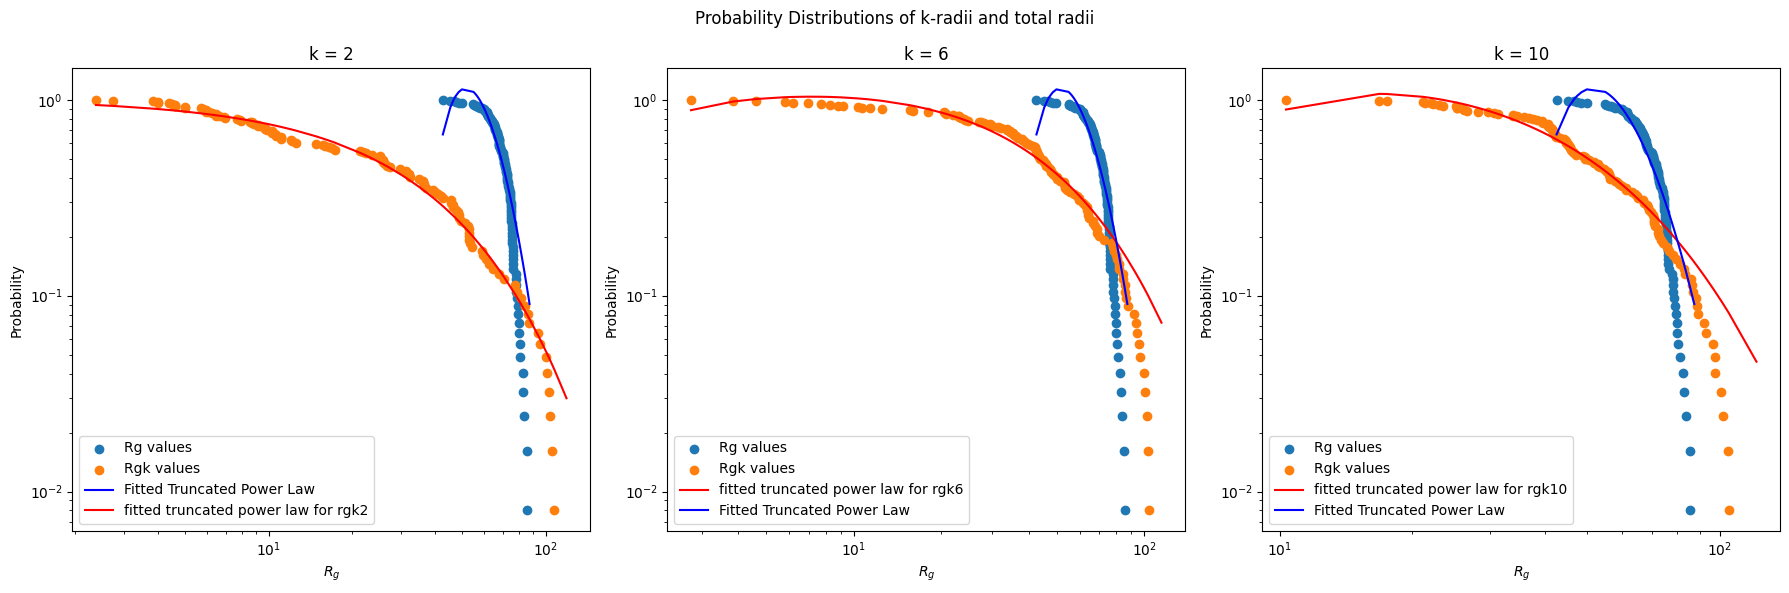

Fitted Parameters:
 r0 = -33.47057294165338
 a = -2.846173775624445
 rcut = 6.362180999487376


In [17]:
from scipy.optimize import curve_fit

arrayrg = np.array(sorted(Rg1), dtype=np.float64)
arrayrgk2 = np.array(sorted(second_elements), dtype=np.float64)
arrayrgk6 = np.array(sorted(sixth_elements), dtype=np.float64)
arrayrgk10 = np.array(sorted(tenth_elements), dtype=np.float64)


# Truncated Power Law Function
def truncated_power_law(Rg, r0, a, rcut):
    return (Rg + r0)**(-a) * np.exp(-Rg / rcut) 


initial_guesses = [59.566962989424855, 3.5263927061728717, 50.627239926990367]

# Example: Using the Trust Region Reflective algorithm

params10, covariance10 = curve_fit(truncated_power_law, arrayrgk10, np.linspace(1, 0, num=len(arrayrgk10)), maxfev = 10000, method='trf')

params, covariance = curve_fit(truncated_power_law, arrayrg, np.linspace(1, 0, num=len(arrayrg)), p0=initial_guesses, maxfev = 10000, method='trf')
params6, covariance6 = curve_fit(truncated_power_law, arrayrgk6, np.linspace(1, 0, num=len(arrayrgk6)), maxfev = 10000, method='trf')
params2, covariance2 = curve_fit(truncated_power_law, arrayrgk2, np.linspace(1, 0, num=len(arrayrgk2)), maxfev = 10000, method='trf')


# Parameters

r02, a2, rcut2 = params2
r06, a6, rcut6 = params6
r0, a, rcut = params
r010, a10, rcut10 = params10



# Plotting the original data and the fitted curve
plt.figure(figsize=(18, 6))

plt.subplot(1,3,1)
plt.scatter(arrayrg, np.linspace(1, 0, num=len(arrayrg)), label='Rg values')
plt.scatter(arrayrgk2, np.linspace(1, 0, num=len(arrayrgk2)), label='Rgk values')
plt.plot(arrayrg, truncated_power_law(arrayrg, *params), color='blue', label='Fitted Truncated Power Law')
plt.plot(arrayrgk2, truncated_power_law(arrayrgk2, *params2), color = 'red', label='fitted truncated power law for rgk2')
plt.xlabel('$R_g$')
plt.ylabel('Probability')
plt.title('k = 2')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.subplot(1, 3, 2)
plt.scatter(arrayrg, np.linspace(1, 0, num=len(arrayrg)), label='Rg values')
plt.scatter(arrayrgk6, np.linspace(1, 0, num=len(arrayrgk6)), label='Rgk values')
plt.plot(arrayrgk6, truncated_power_law(arrayrgk6, *params6), color = 'red', label='fitted truncated power law for rgk6')
plt.plot(arrayrg, truncated_power_law(arrayrg, *params), color='blue', label='Fitted Truncated Power Law')
plt.xlabel('$R_g$')
plt.ylabel('Probability')
plt.title('k = 6')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.subplot(1,3,3)
plt.scatter(arrayrg, np.linspace(1, 0, num=len(arrayrg)), label='Rg values')
plt.scatter(arrayrgk10, np.linspace(1, 0, num=len(arrayrgk10)), label='Rgk values')
plt.plot(arrayrgk10, truncated_power_law(arrayrgk10, *params10), color = 'red', label='fitted truncated power law for rgk10')
plt.plot(arrayrg, truncated_power_law(arrayrg, *params), color='blue', label='Fitted Truncated Power Law')
plt.xlabel('$R_g$')
plt.ylabel('Probability')
plt.title('k = 10')
plt.legend()
plt.xscale('log')
plt.yscale('log')

# Add a single title for all plots
plt.suptitle('Probability Distributions of k-radii and total radii')

plt.tight_layout()
plt.show()

# Print the fitted parameters
print(f"Fitted Parameters:\n r0 = {r0}\n a = {a}\n rcut = {rcut}")

In [18]:

x_data = np.array([34.36675296, 36.8910677,38.45803644, 41.28443461, 43.06663745, 48.04838922,
 48.98085469, 49.17804585, 50.72596458, 51.33515179, 51.92983326, 52.54397764,
 52.98767057, 53.43180601, 53.44661181, 53.74279414, 53.97077625, 57.46866624,
 57.84482098, 57.98542493, 58.28764762, 59.54494351, 59.78206987, 59.82829939,
 59.98850476, 60.2418673 , 60.71691946, 61.02592458, 61.4797954,  62.01153469,
 62.45346612, 62.81540395, 62.90727599, 63.16872941, 63.20017203, 63.24941018,
 63.6391498,  63.93990211, 63.98962457, 64.20204973, 64.83805225, 64.86483663,
 64.92575989, 65.03959782, 65.56800817, 65.63042761, 65.6398844 , 65.67894441,
 66.18115232, 66.8876521 , 67.61241591, 67.6643572 , 67.87994267, 67.99394371,
 67.99796398, 68.32961189, 68.35715153, 68.36238736, 68.50366469, 68.69519274,
 69.18979201, 69.24721705, 69.50372681, 69.69677754, 69.70040532, 70.02011886,
 70.20006465, 70.48519379, 70.523709,   70.71281015, 70.97790195, 71.20728096,
 71.29564061, 71.53247674, 71.90206684, 71.91372744, 72.00880809, 72.24510105,
 72.34422425, 73.39481327, 74.25589647, 74.25673331, 74.37548941, 74.66265757,
 74.69121065, 74.81724357, 75.44736666, 76.07585906, 76.1714455,  76.8817848,
 77.07291223, 77.07612362, 77.12890231, 77.45684464, 77.59568284, 77.61198258,
 78.45301106, 79.26848489, 79.28865862, 79.36454548, 79.56408927, 79.83369549,
 80.10468127, 80.29727265, 81.82414926, 81.91311664, 83.32960647, 84.14609227,
 84.50782883, 84.5717068,  85.97084188, 87.71384418, 89.61721689, 94.01070719,
 99.35035852])

In [19]:
data = {
    '  ': ['rg⁽²⁾', 'rg⁽⁶⁾', 'rg⁽¹⁰⁾', 'rg'],
    'r\u2080': [r02,  r06, r010, r0],
    '\u03B1': [-(a2), -(a6), -(a10), -(a)],
    'r\u1d3b\u02e2': [rcut2, rcut6, rcut10, rcut]
}

df = pd.DataFrame(data)
print(tabulate(df, headers ='keys', tablefmt='pretty'))

+---+--------+--------------------+-----------------------+-------------------+
|   |        |         r₀         |           α           |        rᴻˢ        |
+---+--------+--------------------+-----------------------+-------------------+
| 0 | rg⁽²⁾  | 3656.4170276585733 | 0.0011896488386369094 | 33.80723762627209 |
| 1 | rg⁽⁶⁾  | -1.994355289807002 |  0.14904263785178964  | 34.50974926353601 |
| 2 | rg⁽¹⁰⁾ | -7.965205648691417 |  0.32640536339305787  | 26.22492441700765 |
| 3 |   rg   | -33.47057294165338 |   2.846173775624445   | 6.362180999487376 |
+---+--------+--------------------+-----------------------+-------------------+


125
125


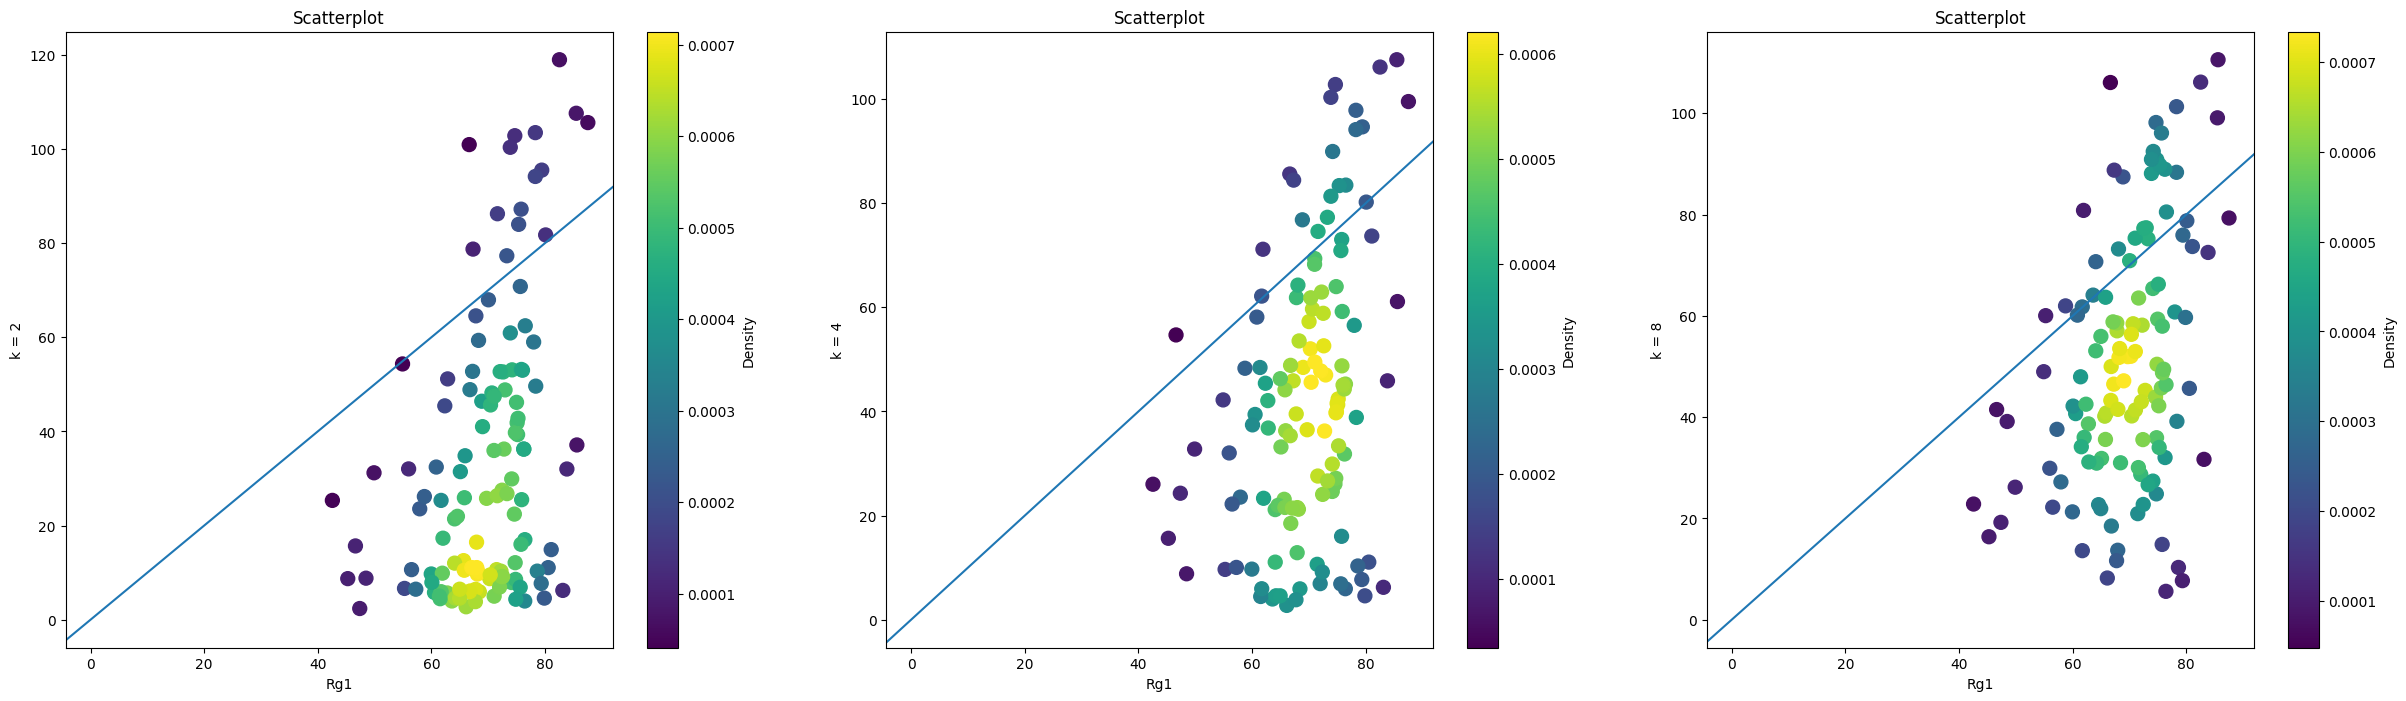

In [20]:
print(len(second_elements))
# problem with different lengths, possible: leave away : and just use values[2]???
print(len(Rg1))

fig, axs = plt.subplots(1, 3, figsize=(30, 8))  # 1 row, 3 columns

# calculation of KDE
xy = np.vstack([Rg1, second_elements])
z = gaussian_kde(xy)(xy)

# Erster Subplot
hb = axs[0].scatter(Rg1, second_elements, c=z, s=100)
axs[0].set_title('Scatterplot')
axs[0].set_xlabel('Rg1')
axs[0].set_ylabel('k = 2')
axs[0].axline((0, 0), slope=1)

# Add colorbar
cb = plt.colorbar(hb)
cb.set_label('Density')

# calculation of KDE
xy = np.vstack([Rg1, fourth_elements])
z1 = gaussian_kde(xy)(xy)

# Erster Subplot
hb = axs[1].scatter(Rg1, fourth_elements, c=z1, s=100)
axs[1].set_title('Scatterplot')
axs[1].set_xlabel('Rg1')
axs[1].set_ylabel('k = 4')
axs[1].axline((0, 0), slope=1)

# Add colorbar
cb = plt.colorbar(hb)
cb.set_label('Density')

# calculation of KDE
xy = np.vstack([Rg1, eight_elements])
z2 = gaussian_kde(xy)(xy)

# Erster Subplot
hb = axs[2].scatter(Rg1, eight_elements, c=z2, s=100)
axs[2].set_title('Scatterplot')
axs[2].set_xlabel('Rg1')
axs[2].set_ylabel('k = 8')
axs[2].axline((0, 0), slope=1)

# Add colorbar
cb = plt.colorbar(hb)
cb.set_label('Density')

plt.show()

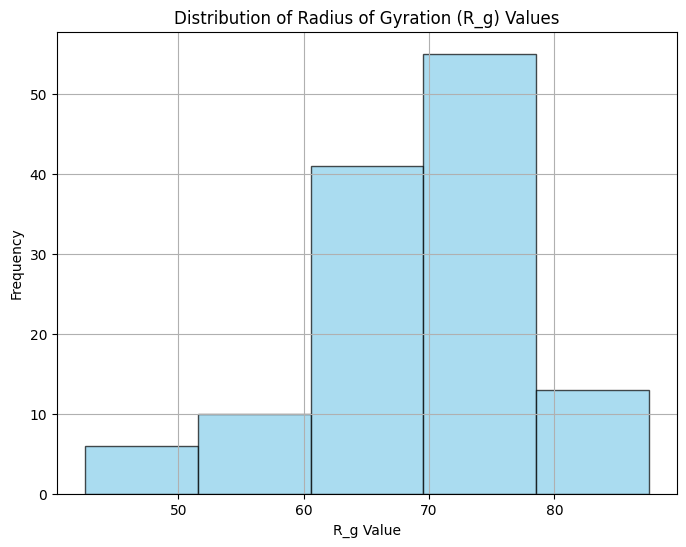

In [21]:
plt.figure(figsize=(8, 6))

plt.hist(Rg1, bins=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('R_g Value')
plt.ylabel('Frequency')
plt.title('Distribution of Radius of Gyration (R_g) Values')

plt.grid(True)
plt.show()

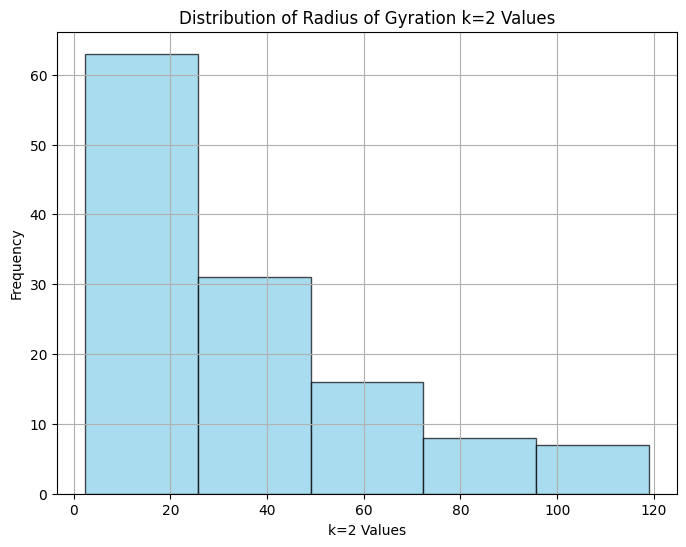

In [22]:
plt.figure(figsize=(8, 6))

plt.hist(second_elements, bins=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('k=2 Values')
plt.ylabel('Frequency')
plt.title('Distribution of Radius of Gyration k=2 Values')

plt.grid(True)
plt.show()

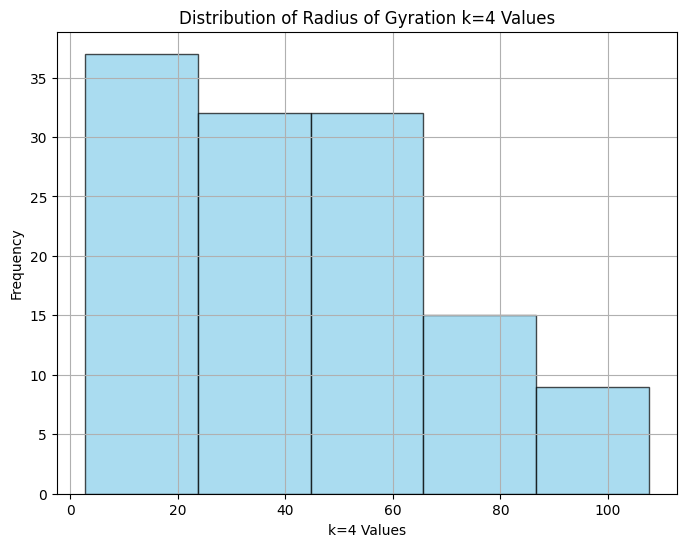

In [23]:
plt.figure(figsize=(8, 6))

plt.hist(fourth_elements, bins=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('k=4 Values')
plt.ylabel('Frequency')
plt.title('Distribution of Radius of Gyration k=4 Values')

plt.grid(True)
plt.show()

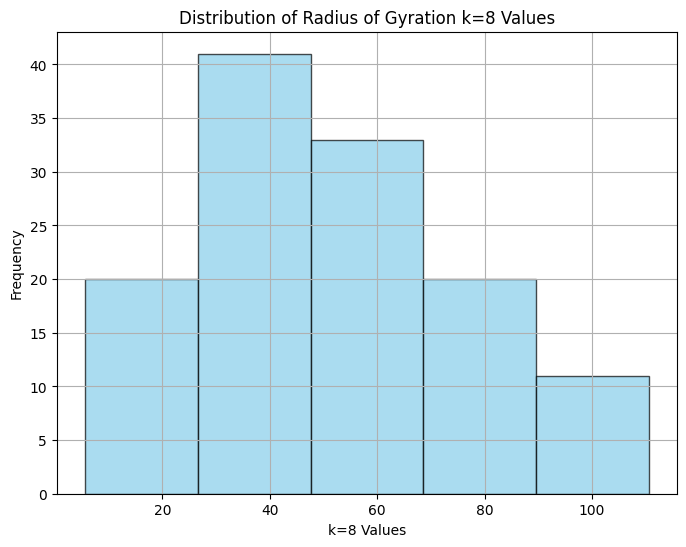

In [24]:
plt.figure(figsize=(8, 6))

plt.hist(eight_elements, bins=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('k=8 Values')
plt.ylabel('Frequency')
plt.title('Distribution of Radius of Gyration k=8 Values')

plt.grid(True)
plt.show()

In [25]:
print(participants)
print(len(participants))
print(len(Rgk))
print(Rgk)
print(session)
print(len(session))

[1005, 1005, 1005, 1005, 1005, 1008, 1008, 1008, 1008, 1008, 1010, 1010, 1010, 1010, 1010, 1011, 1011, 1011, 1011, 1011, 1013, 1013, 1013, 1013, 1013, 1017, 1017, 1017, 1017, 1017, 1018, 1018, 1018, 1018, 1018, 1019, 1019, 1019, 1019, 1019, 1021, 1021, 1021, 1021, 1021, 1022, 1022, 1022, 1022, 1022, 1023, 1023, 1023, 1023, 1023, 1054, 1054, 1054, 1054, 1054, 1055, 1055, 1055, 1055, 1055, 1056, 1056, 1056, 1056, 1056, 1057, 1057, 1057, 1057, 1057, 1058, 1058, 1058, 1058, 1058, 1068, 1068, 1068, 1068, 1068, 1069, 1069, 1069, 1069, 1069, 1072, 1072, 1072, 1072, 1072, 1073, 1073, 1073, 1073, 1073, 1074, 1074, 1074, 1074, 1074, 1075, 1075, 1075, 1075, 1075, 1077, 1077, 1077, 1077, 1077, 1079, 1079, 1079, 1079, 1079, 1080, 1080, 1080, 1080, 1080]
125
125
[[0.0, 6.103774133556169, 8.571676583713497, 18.50227940315044, 16.637037609146745, 15.575131303974757, 15.828948222562667, 18.50227940315044, 17.495766683739582, 16.834818374246797], [0.0, 54.32668671002209, 48.95561523844314, 42.2215243454

In [26]:
import csv

sessions = []

# Create a DataFrame from the lists
df = pd.DataFrame({'IDs': participants, 'session': session, 'Rg': Rg1, 'k=2': second_elements, 'k=3': third_elements, 'k=4': fourth_elements, 'k=5': fifth_elements, 'k=6': sixth_elements, 'k=7': seventh_elements,
                   'k=8': eight_elements, 'k=9': ninth_elements, 'k=10': tenth_elements})

# Write the DataFrame to a CSV file
df.to_csv('cont.csv', index=False)

print(f"Data has been written successfully.")

Data has been written successfully.


/tmp/ipykernel_7037/1681870619.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels for better readability
/tmp/ipykernel_7037/1681870619.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels for better readability
/tmp/ipykernel_7037/1681870619.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels for better readability
/tmp/ipykernel_7037/1681870619.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get

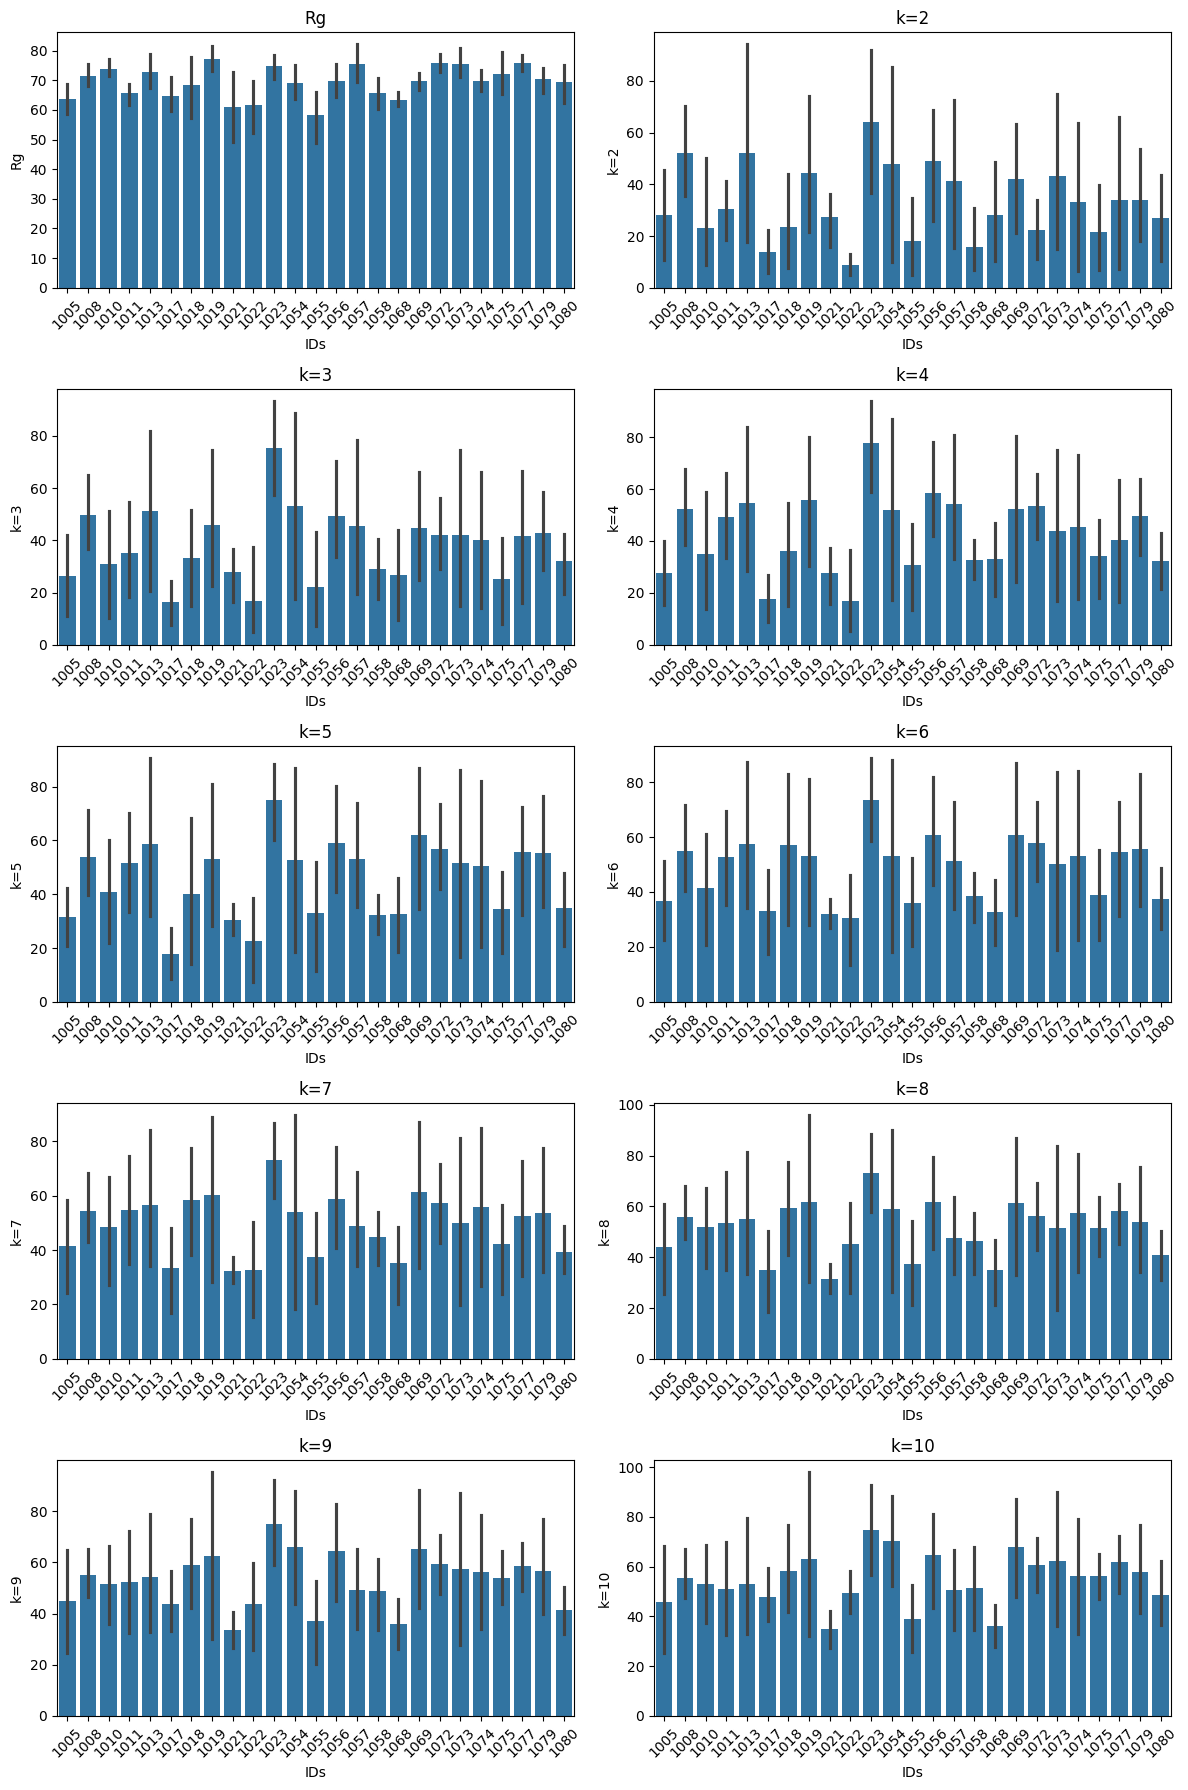

In [27]:
# Create a figure and axis objects
fig, axes = plt.subplots(5, 2, figsize=(12, 18))  # 5 rows, 2 columns for 10 subplots

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Iterate over each column (except the first one if it's an index column)
for i, column in enumerate(df.columns[2:]):
    ax = axes[i]  # Get the current axis
    sns.barplot(x='IDs', y=column, data=df, ax=ax)  # Create the bar plot
    ax.set_title(column)  # Set the title of the subplot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

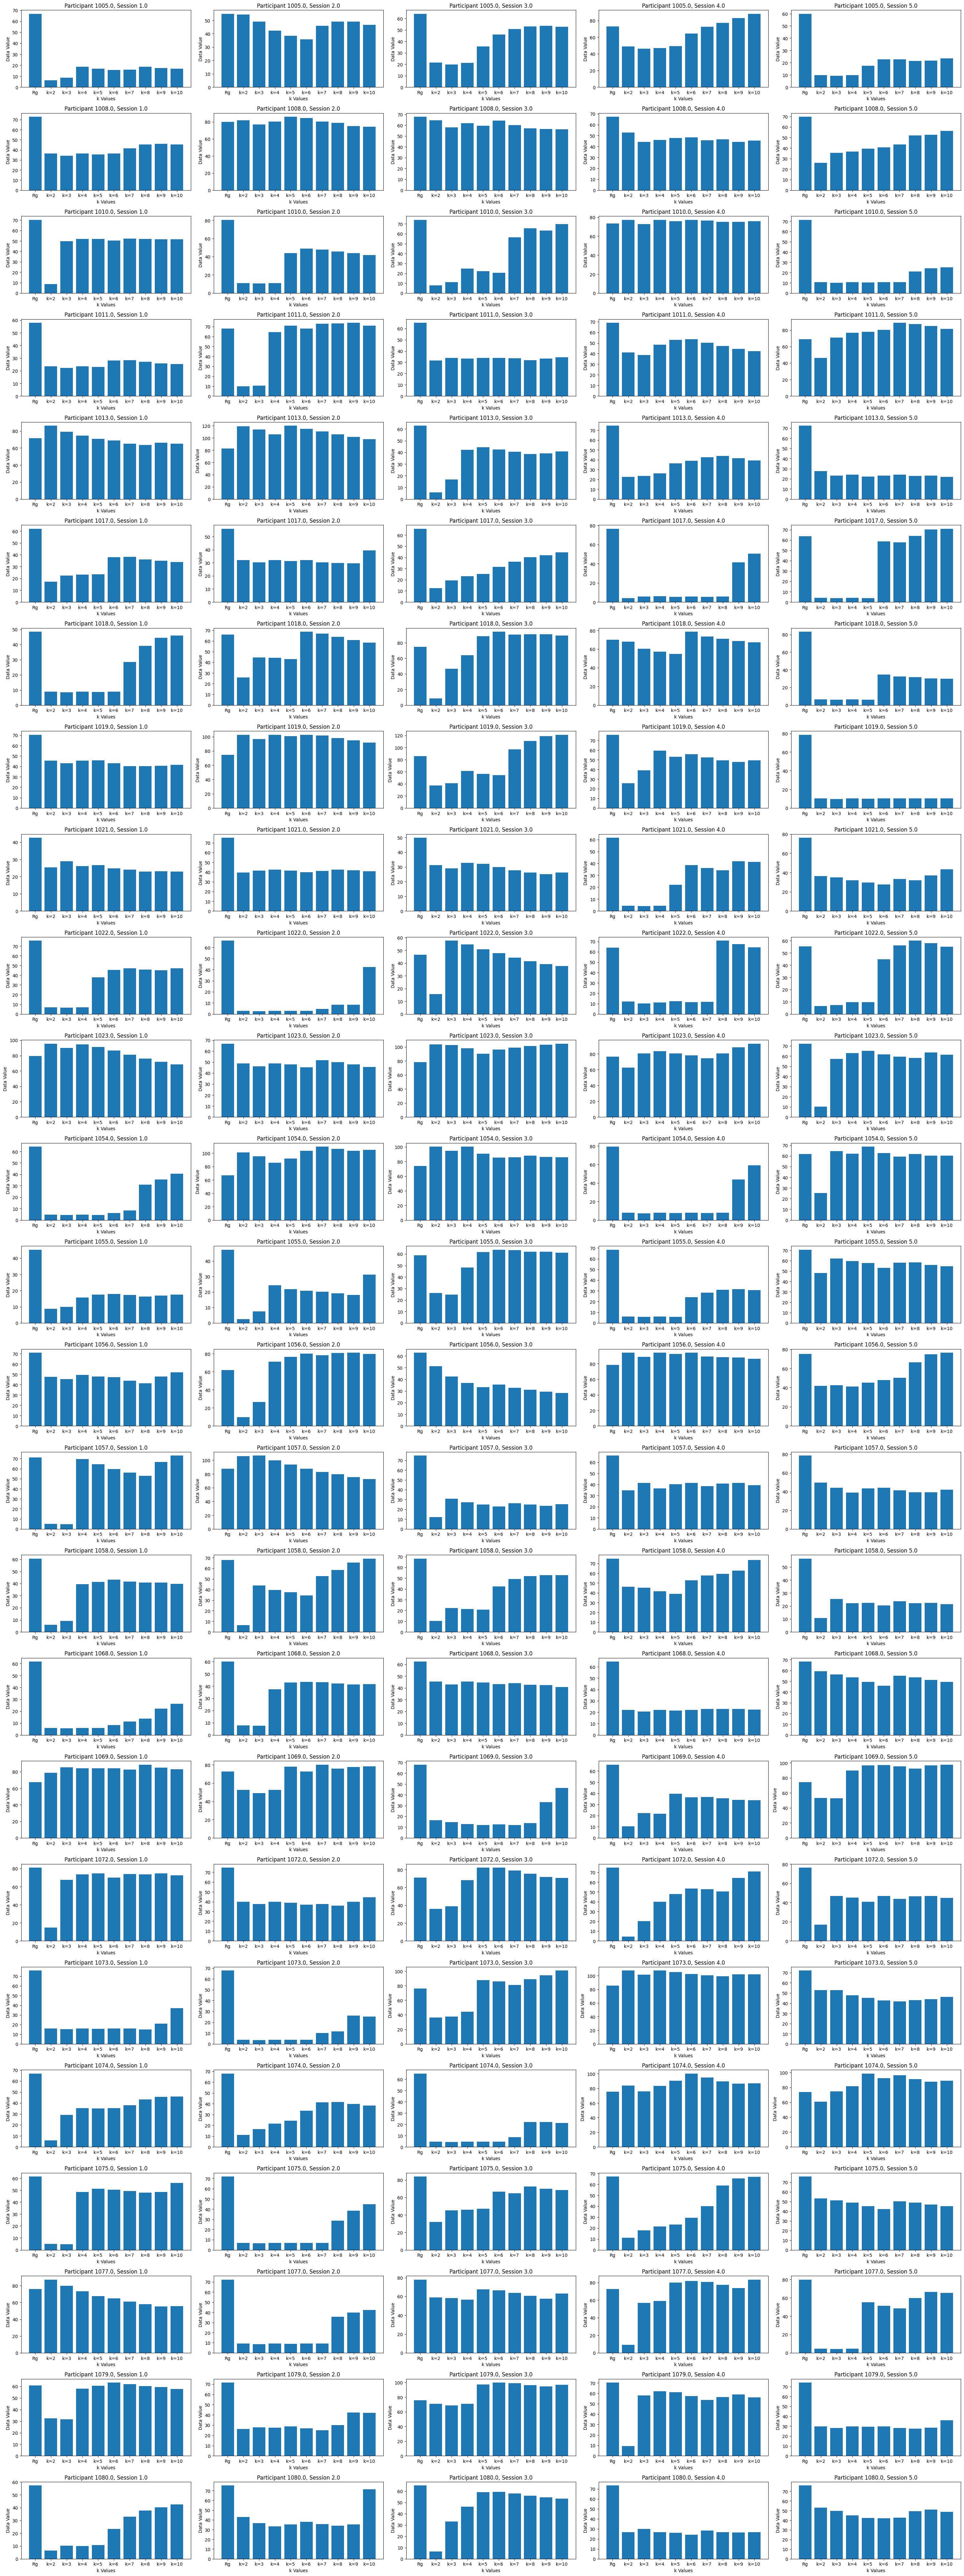

In [30]:
# Drop the 'IDs' column to get only the data values
data = df.drop(['IDs', 'session'], axis=1)

fig, axes = plt.subplots(25, 5, figsize=(30, 80))  # 25 rows, 5 columns for 125 subplots

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

for i, (index, row) in enumerate(df.iterrows()):
    participant_id = row['IDs']
    sessions = row['session']
    participant_data = row.drop(['IDs', 'session'])  # Drop the ID column from the row
    ax = axes[i]
    ax.bar(data.columns, participant_data)
    ax.set_title(f'Participant {participant_id}, Session {sessions}')
    ax.set_xlabel('k Values')
    ax.set_ylabel('Data Value')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [33]:
nodes, X, Y = get_nodes_and_coordinates_trial(1080,1)
len(nodes)

99

In [35]:
rg_v = []
n_v = []
for i  in range(1, 100):
    nodes, coor_x, coor_y = get_nodes_and_coordinates_trial(1080, 1)
    # get the values for rg 
    N = get_length(nodes[:i])
    n_v.append(N)
    ri = get_vector(1080, 1)
    rcm = (np.mean(coor_x[:i]), np.mean(coor_y [:i]))
    ni = ni_c(nodes[:i])
    rg_v.append(calculate_rg(N, ni, ri[:i], rcm))

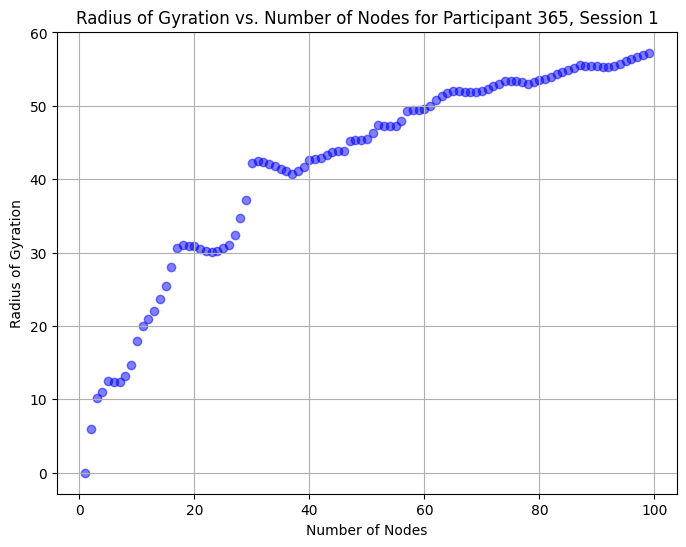

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(n_v, rg_v, color='blue', alpha=0.5)
plt.title('Radius of Gyration vs. Number of Nodes for Participant 1080, Session 1')
plt.xlabel('Number of Nodes')
plt.ylabel('Radius of Gyration')
plt.grid(True)
plt.show()

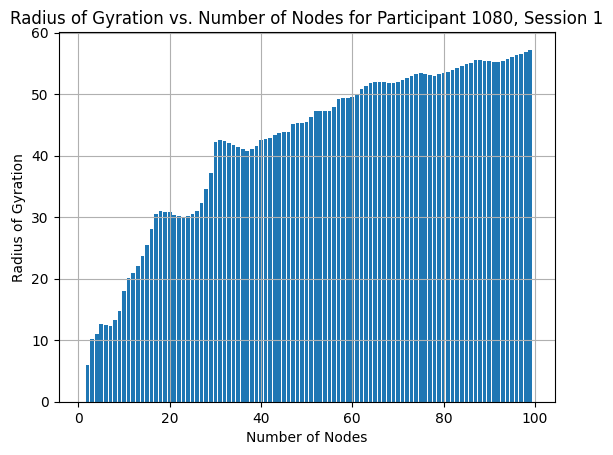

In [37]:
plt.bar(n_v, rg_v)
plt.title('Radius of Gyration vs. Number of Nodes for Participant 1080, Session 1')
plt.xlabel('Number of Nodes')
plt.ylabel('Radius of Gyration')
plt.grid(True)
plt.show()

In [38]:
df.at[0, 'Rg']

66.8166866670274

In [39]:
def bisector_method(df, k):
    # rg(k) > rg/2
    for i, row in df.iterrows(): #iterate over each row
        if row[f'k={k}'] > (row['Rg'] / 2 ): # if rg(k) > rg/2
            returners.append((row['IDs'], row['session'])) # returner
        else:
            explorers.append((row['IDs'], row['session'])) # explorer

for k in range(2, 11):
    returners = []
    explorers = []
    bisector_method(df, k)
    print(f'K = {k}: Numbers returners: {len(returners)}, Numbers of explorers: {len(explorers)}')


K = 2: Numbers returners: 50, Numbers of explorers: 75
K = 3: Numbers returners: 65, Numbers of explorers: 60
K = 4: Numbers returners: 77, Numbers of explorers: 48
K = 5: Numbers returners: 81, Numbers of explorers: 44
K = 6: Numbers returners: 88, Numbers of explorers: 37
K = 7: Numbers returners: 95, Numbers of explorers: 30
K = 8: Numbers returners: 92, Numbers of explorers: 33
K = 9: Numbers returners: 101, Numbers of explorers: 24
K = 10: Numbers returners: 106, Numbers of explorers: 19


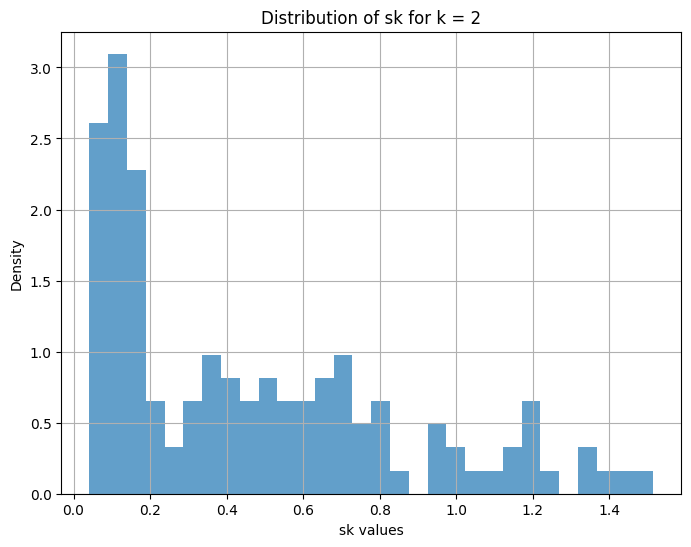

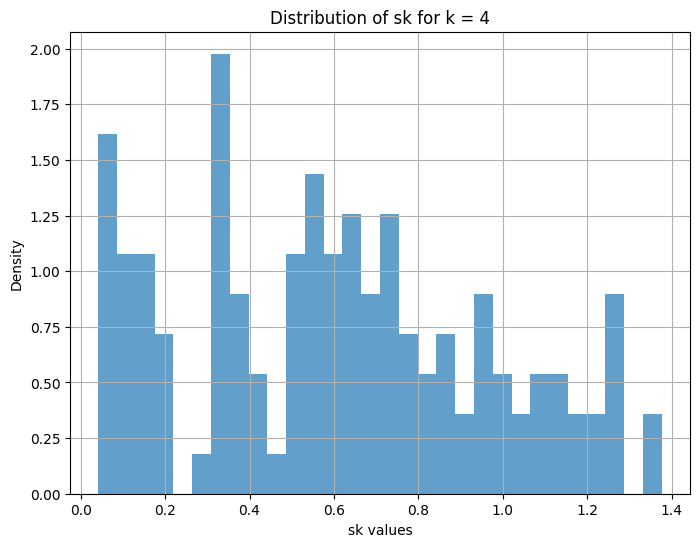

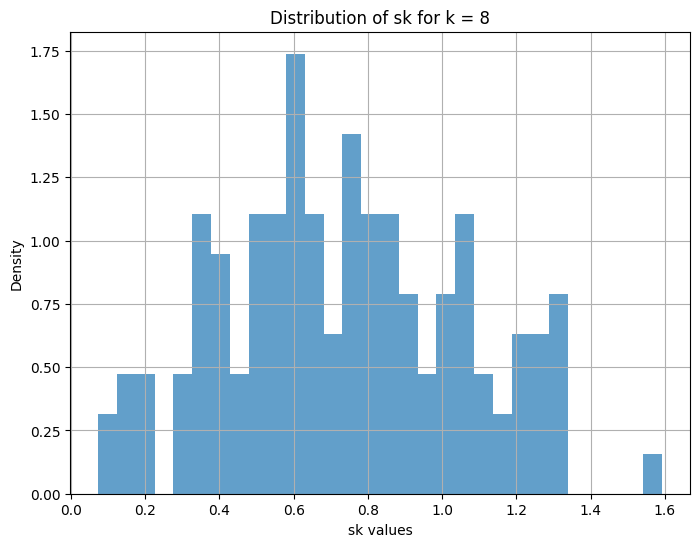

In [40]:
def calculate_sk(df, k):
    skvalues = df[f'k={k}'] / df['Rg']
    return skvalues

def plot_distribution_sk(skvalues, k):
    plt.figure(figsize = (8,6))
    plt.hist(skvalues, bins=30, density=True, alpha=0.7)
    plt.title(f"Distribution of sk for k = {k}")
    plt.xlabel("sk values")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

ks = [2,4,8]

for k in ks:
    sk_values = calculate_sk(df, k)
    plot_distribution_sk(sk_values, k)



In [41]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


In [42]:
# Replace 'help.csv' with your actual data file
df = pd.read_csv('help.csv')

# Assuming df has columns 'rg' and 'rg_k'
rg = df['Rg']
rg_k = df['k=2']


In [43]:
# Bisector method classification
df['bisector_class'] = np.where(rg_k > rg / 2, 'k-returner', 'k-explorer')


In [44]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X = df[['Rg', 'k=2']]
y = df['bisector_class']  # Using bisector method results as initial labels for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

# Predict using SVM
df['svm_class'] = svm_classifier.predict(X)


In [45]:
# Fit EM clustering algorithm
em = GaussianMixture(n_components=2, random_state=42)
df['em_class'] = em.fit_predict(X)

# Map clusters to 'k-returner' and 'k-explorer' based on means or another criterion
# Here we assume cluster 0 corresponds to 'k-explorer' and 1 to 'k-returner'
df['em_class'] = df['em_class'].map({0: 'k-explorer', 1: 'k-returner'})


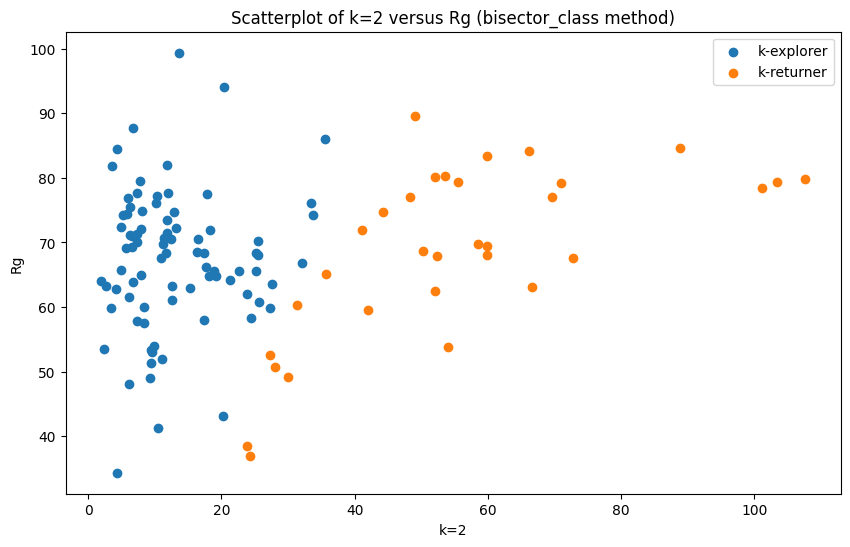

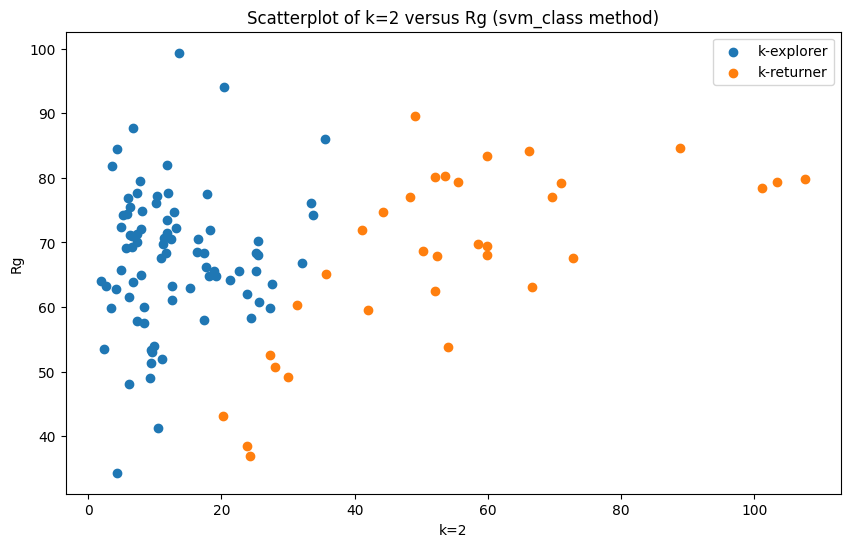

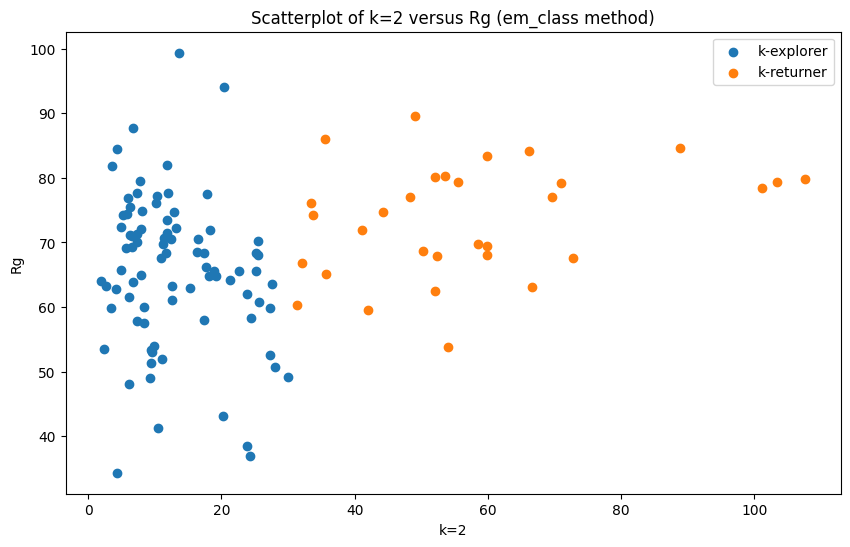

In [46]:
def plot_classification(df, method, x='k=2', y='Rg'):
    plt.figure(figsize=(10, 6))
    groups = df.groupby(method)
    for name, group in groups:
        plt.scatter(group[x], group[y], label=name)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'Scatterplot of {x} versus {y} ({method} method)')
    plt.legend()
    plt.show()

# Plot results
plot_classification(df, 'bisector_class')
plot_classification(df, 'svm_class')
plot_classification(df, 'em_class')


In [47]:
connection.close()